<a href="https://colab.research.google.com/github/JEduardoDimasR/Proyecto-personal/blob/main/Pron%C3%B3stico_de_transacciones_en_una_cadena_de_tiendas_minoristas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cargar librerías

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import GRU, Dense

## Cargar datos

In [25]:
store_df = pd.read_excel("store.xls")

## Comprender la información de los datos

In [26]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          115 non-null    datetime64[ns]
 1   Transactions  115 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 KB


In [27]:
store_df.shape

(115, 2)

Se cuenta con un conjunto de datos de 115 observaciones y 2 variables, una de tipo númerica y otra de tipo temporal.


In [28]:
store_df.set_index(pd.to_datetime(store_df.Date),inplace=True)
store_df.drop("Date", axis = 1, inplace = True)
store_df[-5:]

,Transactions
Date,
2015-01-19,18
2015-01-20,22
2015-01-21,22
2015-01-22,21
2015-01-23,17


## Visualizar la serie de tiempo

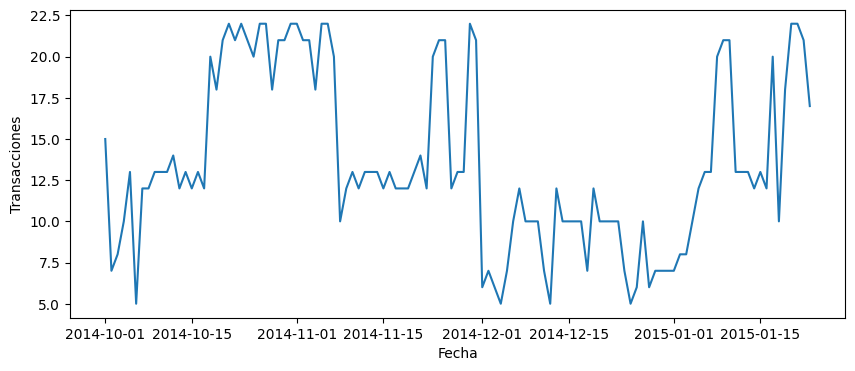

In [29]:
plt.figure( figsize=(10,4))
plt.xlabel( "Fecha" )
plt.ylabel( "Transacciones" )
plt.plot( store_df.Transactions )

La serie presenta varias fluctuaciones, lo cuál muestra que es necesario visualizar de manera mas detallada sus componentes.

## Descomposición de la serie de tiempo en sus componentes

Para descomponer la serie de tiempo en sus componentes, se utilizara el modelo multiplicativo, el cuál viene dado por:

$$Y_t=T_t*S_t*C_t*I_t$$

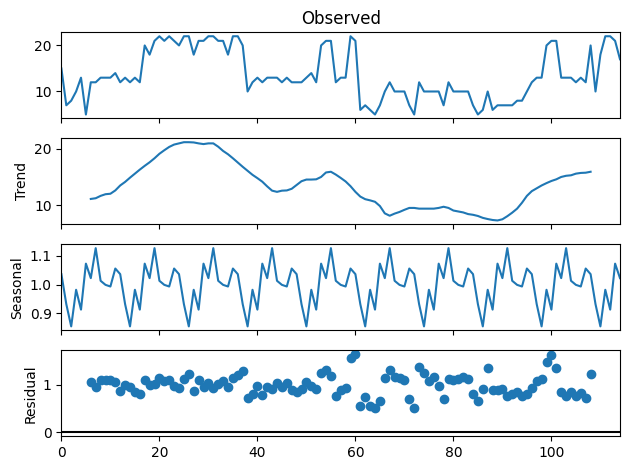

In [33]:
ts_decompose = seasonal_decompose(np.array(store_df["Transactions"]), model="multiplicative", period = 12)
## Plotting the deocomposed time series components
ts_plot = ts_decompose.plot()

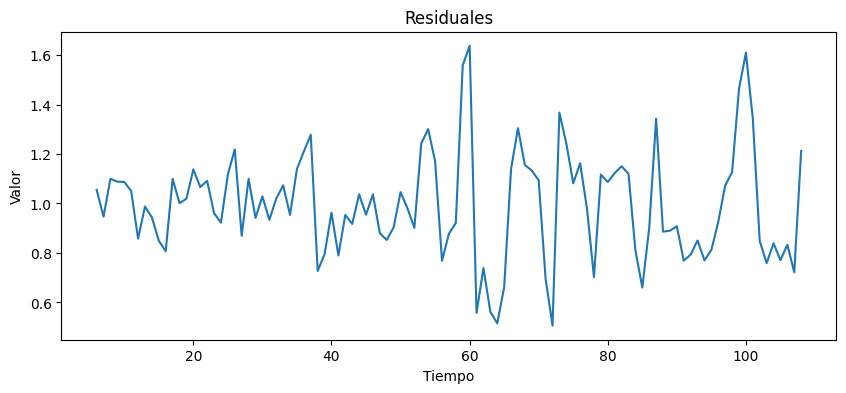

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

ts_decompose = seasonal_decompose(np.array(store_df["Transactions"]), model="multiplicative", period = 12)

# Obteniendo los residuos
residuals = pd.Series(ts_decompose.resid)

# Creando un gráfico de los residuos sin puntos
plt.figure(figsize=(10, 4))
plt.plot(residuals.index, residuals.values, linestyle='-', marker='')  # Configurando el marcador como vacío para eliminar puntos
plt.title('Residuales')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.show()